### imports

In [63]:
import os
import warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import cvxpy as cp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from IPython.display import clear_output

from ipynb.fs.full.optimizedTIO_paper import refAccuracyScheduler

clear_output()

### utils

In [64]:
"""
elements
"""

def projection_simplex(vector,args=None):
    if args is None:
        radius = 1
    else:
        radius = args[0]
    n_features = vector.shape[0]
    u = np.sort(vector)[::-1]
    cssv = np.cumsum(u) - radius
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(vector - theta, 0)
    return w

In [65]:
"""
(inexact FOIO) FGD
"""
def FGD(x0,f_oracle,Psi=lambda u: 0, proxPsi = lambda u,g,ss: u, accuracy_schedule=np.zeros(int(1e3)), L=1.0,m=0.0,mu=0.0,verbose=True,freq=10,synthetic_radius=np.inf,main=1.0,keep=True):
    
    h_grad = lambda u: u # relative smoothness kernel's gradient
    
    # init.
    k = 0
    x,y,v = x0.copy(),x0.copy(),x0.copy()
    dimension = len(x)
    if type(L)==type([]):
        L_schedule = L.copy()
    else :
        L_schedule = L*np.ones(len(accuracy_schedule))
        
    s = mu+m
    A = 0

    # storing sequence
    infos = np.array([[0,0]])

    # convergence certificates
    SHRINK,ACCUMULATOR_delta,ACCUMULATOR_free,seed_acc = 1,0,0,1
    
    # main algorithmic loop
    start_ = time.time()
    
    for id_accuracy,delta_k in enumerate(accuracy_schedule):
        
        local_L = L_schedule[id_accuracy] # local model smoothness parameter (update)
        a_plus = ((1+A*s)+((1+A*s+4*A*local_L)**(1/2) * (1+A*s)**(1/2)))/(2*local_L) # new impact
        
        y = (A*x + a_plus*v)/(A+a_plus)
        
        fk,gk = f_oracle(y,'full',accuracy=delta_k) # FOI collection
        Fyk = fk+Psi(y)

        '''
        (eventual) auto-corruption for analysis purposes
        '''
        if synthetic_radius<np.inf:
            rand_dir = np.random.normal(0,1,dimension) 
            gk += rand_dir*(delta_k/synthetic_radius)/sum(rand_dir**2)**(1/2)
        
        time_k = time.time()-start_
        if verbose and (k % freq == 0) and k>0:
            print("k = %i, value = %e, totTime = %e, err. acc = %e, primal cert. = %e" %
                  (k,Fyk,time_k,ACCUMULATOR_delta,main*SHRINK+ACCUMULATOR_delta))
            print(' ')
            
        v = proxPsi(h_grad(v)*local_L*a_plus/(A+a_plus) + h_grad(y)*mu, gk, stepsize=(mu+local_L*a_plus/(A+a_plus))**(-1)) # PROXIMAL step 1
        x = (A*x + a_plus*v)/(A+a_plus)
        
        if keep:
                        
            infos = np.vstack((infos,np.array([[Fyk,time_k]]))) # storage time 

        k += 1 # updates of iteration counter and accumulators
        ACCUMULATOR_free = A+a_plus
        ACCUMULATOR_delta = ACCUMULATOR_delta*A/(A+a_plus) + delta_k
        A += a_plus
        SHRINK = 1/ACCUMULATOR_free
        
        if main*SHRINK+ACCUMULATOR_delta<=1e-50:
            return x
            

    if keep:            
        
        return x,np.array(infos[1:])
    
    else:
        
        return x

### information oracles elements

In [69]:
# dimensions & data

np.random.seed(2404)

'''error allowed
=> eps_allowed = sup prox over admissible dom / upsilon ; simplex of size 1 => max achieved at one entry matching 1
''' 
eps_error = 1e-2

d = int(100)
n = int(5e2)
strong = 1e-1
upsilon_def = np.log(n)/eps_error

O_def = np.random.normal(0,1/10,(n,d))

x0 = projection_simplex(np.random.uniform(0,1,d))

amplitude = upsilon_def*np.linalg.norm(O_def,2)**2

def SM_oracle(x,mode='value',O=O_def,upsilon=upsilon_def):
    Ox = O@x
    max_Ox = np.max(Ox)
    shifted_exp = np.exp(upsilon*(Ox-max_Ox))
    sum_shifted_exp = np.sum(shifted_exp)
    if mode=='value':
        if upsilon>0:
            return max_Ox + 1/upsilon*np.log(sum_shifted_exp/len(Ox)) + strong*sum(x**2)/2
        else:
            return np.mean(Ox) + strong*sum(x**2)/2
    elif mode=='gradient':
        if upsilon>0:
            return O.T@(shifted_exp/sum_shifted_exp) + strong*x
        else:
            return np.mean(O,0) + strong*x
    else:
        if upsilon>0:
            return max_Ox + 1/upsilon*np.log(sum_shifted_exp/len(Ox)) + strong*sum(x**2)/2, O.T@(shifted_exp/sum_shifted_exp)+strong*x
        else:
            return np.mean(Ox)+ strong*sum(x**2)/2,np.mean(O,0)+strong*x


* $O = [\theta_1,\dots,\theta_n]^T\in \mathbb{R}^{n \times d}$ data matrix 
* $f : \mathbb{R}^d \to \mathbb{R}, \, x \to f(x) = \upsilon^{-1}\,\log\Big(n^{-1}\,\sum_{i=1}^{n}\,\text{exp}(\upsilon\,\langle \theta_i,x\rangle)\Big) + \frac{\mu}{2}||x||^2$ (regularized `MellowMax` **function**) 

In [70]:
def myPsi(x):
    if abs(1-sum(x))<=1e-4:
        return 0
    else:
        return np.inf

def myProxPsi(anchor, direction, stepsize):
    return projection_simplex(-stepsize*(direction-anchor))

In [71]:
amplitude

6388.58032056101

### optimization time (synthetic)

In [72]:
## getting reference solutions..

In [73]:
# hard 
x_var = cp.Variable(d,nonneg=True)
cstr = [cp.sum(x_var)==1]
fun_obj = cp.max(O_def@x_var)  + strong/2*cp.sum_squares(x_var)
obj = cp.Minimize(fun_obj) 
prob = cp.Problem(obj,cstr)
prob.solve(solver=cp.MOSEK,verbose=True)
true_hard_x = x_var.value

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Aug 29 07:13:46 PM: Your problem has 100 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 29 07:13:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 29 07:13:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 29 07:13:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 29 07:13:46 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 29 07:13:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [74]:
strong/2*sum(true_hard_x**2)

0.0007924623770190347

In [75]:
GAIN_HARD = np.max(O_def@x0)/np.max(O_def@true_hard_x)
GAIN_HARD

8.029420121359795

In [76]:
# soft 
true_soft_x_FGD = FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=np.zeros(int(3e5)), L=amplitude+strong,m=0.0,mu=strong,verbose=True,freq=10000,synthetic_radius=np.inf,main=1.0,keep=False)

k = 10000, value = 9.867332e-03, totTime = 1.163041e+00, err. acc = 0.000000e+00, primal cert. = 2.590678e-18
 
k = 20000, value = 9.867332e-03, totTime = 2.284811e+00, err. acc = 0.000000e+00, primal cert. = 1.703045e-35
 


In [77]:
F_star = SM_oracle(true_soft_x_FGD)
F_star

0.009867332278674933

In [78]:
abs(fun_obj.value-F_star)<=eps_error

True

### `experiment` 

multiple variations of $\bar{\delta}$ and $N_r$ in <i>offline</i> schedules

In [79]:
Nr_list = [100,500,1000,5000,10000]
bar_delta_list = [9e-3,1e-4,1e-6]
r_list = [0,1/2,1,2]
M = 100

sr = 1/100 # synthetic radius 'alpha'

In [80]:
len(Nr_list)*len(bar_delta_list)*len(r_list)

60

In [81]:
import pandas as pd
fields = ['N_ref','bar_delta','r','GAP','schedule','condition']
dic_results = {}
for field in fields:
    dic_results[field] = []

In [82]:
condition = np.format_float_scientific(strong/(amplitude+strong),3)

outer_reps = int(5) 
inner_reps = int(5)

for o_rep in range(outer_reps):

    print('OUTER -> '+str(o_rep))

    x0 = projection_simplex(np.random.uniform(0,1,d))
    

    for N_ref in Nr_list:
        for bar_delta in bar_delta_list:
            for r in r_list:
                
                accuracy_ref = refAccuracyScheduler(N_ref,M,bar_delta,r,arguments=[strong,0.0,amplitude+strong],typ='FGD',verbose=False)

                
                print('new scenario || N = '+str(N_ref)+', bar_delta = '+str(bar_delta)+', r = '+str(r))
                print(' ')

                for i_rep in range(inner_reps):

                    print('rep#'+str(i_rep))
                    print(' ')

                    constant_soft_x_FGD = \
                       FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=np.ones(N_ref)*bar_delta, L=amplitude+strong,m=0.0,mu=strong,verbose=False,freq=100,synthetic_radius=sr,main=1.0,keep=False)
                    tunable_soft_x_FGD = \
                       FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=accuracy_ref, L=amplitude+strong,m=0.0,mu=strong,verbose=False,freq=100,synthetic_radius=sr,main=1.0,keep=False)    

                    dic_results['GAP'].append([SM_oracle(constant_soft_x_FGD)+myPsi(constant_soft_x_FGD)-F_star,SM_oracle(tunable_soft_x_FGD)+myPsi(tunable_soft_x_FGD)-F_star])
                    print(dic_results['GAP'][-1])
                    print(' ')
                    dic_results['condition'].append([condition,condition])
                    dic_results['N_ref'].append([N_ref,N_ref])
                    dic_results['bar_delta'].append([bar_delta,bar_delta])
                    dic_results['r'].append([r,r])
                    dic_results['schedule'].append(['constant','tunable'])
                    
                print(' ')
                print(' =========== ')
                print(' ')

OUTER -> 0
new scenario || N = 100, bar_delta = 0.009, r = 0
 
rep#0
 
[0.03518136958662904, 0.029503190062803265]
 
rep#1
 
[0.036723434551185416, 0.02984316003207645]
 
rep#2
 
[0.035838204992967276, 0.03067367269504701]
 
rep#3
 
[0.03722579466945106, 0.030064806247931352]
 
rep#4
 
[0.036445987532536986, 0.03085997467417904]
 
 
 
new scenario || N = 100, bar_delta = 0.009, r = 0.5
 
rep#0
 
[0.03519878543261239, 0.03191355476036829]
 
rep#1
 
[0.03622033293671727, 0.03160964035226718]
 
rep#2
 
[0.036241019121546314, 0.032440607447210015]
 
rep#3
 
[0.03549561467717943, 0.032862020859937294]
 
rep#4
 
[0.03591486318828907, 0.032874992322006344]
 
 
 
new scenario || N = 100, bar_delta = 0.009, r = 1
 
rep#0
 
[0.036509922315315205, 0.03511818601961955]
 
rep#1
 
[0.03611873545446925, 0.034107218874888226]
 
rep#2
 
[0.03702409841865556, 0.03477650249149912]
 
rep#3
 
[0.03550855873376649, 0.03486207356901509]
 
rep#4
 
[0.03568446281589348, 0.03422016473090671]
 
 
 
new scenario 

[0.00019569952271751047, 0.00019569328047995896]
 
rep#3
 
[0.00019569196596701428, 0.00019570038006959563]
 
rep#4
 
[0.00019569378479887892, 0.00019568752247970875]
 
 
 
new scenario || N = 1000, bar_delta = 0.009, r = 0
 
rep#0
 
[0.0016834817992799796, 9.201908703665093e-05]
 
rep#1
 
[0.0012806895071224046, 8.975632881702555e-05]
 
rep#2
 
[0.0013763939846713653, 7.639689231317935e-05]
 
rep#3
 
[0.0014006779996870809, 8.086170129392722e-05]
 
rep#4
 
[0.001486693687950992, 7.509260544018466e-05]
 
 
 
new scenario || N = 1000, bar_delta = 0.009, r = 0.5
 
rep#0
 
[0.0011912270328925736, 0.00034637281081659893]
 
rep#1
 
[0.0012487696748782664, 0.0003283046829462861]
 
rep#2
 
[0.0014313370198587548, 0.00035659120524021183]
 
rep#3
 
[0.0011930723467941245, 0.000343932072748708]
 
rep#4
 
[0.0013242904162229022, 0.00036285332747604433]
 
 
 
new scenario || N = 1000, bar_delta = 0.009, r = 1
 
rep#0
 
[0.0011339115588032689, 0.0005889984072306488]
 
rep#1
 
[0.0012144631173146084

[3.187822228412074e-11, 1.5877802544972397e-12]
 
rep#3
 
[3.550084011483268e-11, 1.6847304801226315e-12]
 
rep#4
 
[5.108527316444178e-11, 1.5535992631265927e-12]
 
 
 
new scenario || N = 5000, bar_delta = 1e-06, r = 2
 
rep#0
 
[5.197735297723938e-11, 5.423623355982343e-12]
 
rep#1
 
[4.073724343967022e-11, 5.599409824696977e-12]
 
rep#2
 
[4.3028589372107184e-11, 6.254710291364596e-12]
 
rep#3
 
[4.8967354476792124e-11, 5.125041016573739e-12]
 
rep#4
 
[3.544439394764787e-11, 5.0965221626286805e-12]
 
 
 
new scenario || N = 10000, bar_delta = 0.009, r = 0
 
rep#0
 
[0.0013799364881797727, 2.0876219156140685e-10]
 
rep#1
 
[0.001480043363469706, 2.392731741907017e-10]
 
rep#2
 
[0.0013876666355703126, 2.8267375766499736e-10]
 
rep#3
 
[0.0010195262283721213, 2.3342771292289566e-10]
 
rep#4
 
[0.0015520760981809004, 2.547678214226412e-10]
 
 
 
new scenario || N = 10000, bar_delta = 0.009, r = 0.5
 
rep#0
 
[0.001229901331597099, 8.943785083544153e-07]
 
rep#1
 
[0.00125120138321710

[0.0355865171498099, 0.03558652965908865]
 
rep#2
 
[0.03558646976211735, 0.035586612895847705]
 
rep#3
 
[0.035586638106238605, 0.03558656538990901]
 
rep#4
 
[0.035586517813493104, 0.0355864057305208]
 
 
 
new scenario || N = 100, bar_delta = 1e-06, r = 2
 
rep#0
 
[0.03558650798358445, 0.03558648294184101]
 
rep#1
 
[0.035586336847326414, 0.03558639090520953]
 
rep#2
 
[0.035586456185703275, 0.03558639816626673]
 
rep#3
 
[0.03558651367636047, 0.03558662786563778]
 
rep#4
 
[0.03558655270326637, 0.0355865494824638]
 
 
 
new scenario || N = 500, bar_delta = 0.009, r = 0
 
rep#0
 
[0.0012854189520293338, 0.0002411851487968339]
 
rep#1
 
[0.0013376776821689522, 0.00017939521919625376]
 
rep#2
 
[0.001224473872051362, 0.0002572249729634636]
 
rep#3
 
[0.0013837607210399616, 0.00022473284084355456]
 
rep#4
 
[0.001432487937751619, 0.0002613587818159277]
 
 
 
new scenario || N = 500, bar_delta = 0.009, r = 0.5
 
rep#0
 
[0.001215858107904172, 0.0005557434824391451]
 
rep#1
 
[0.0015946

[3.099795257460042e-06, 3.0975147143220277e-06]
 
rep#2
 
[3.0980203520394878e-06, 3.1002834568766985e-06]
 
rep#3
 
[3.099080479334465e-06, 3.100989617777286e-06]
 
rep#4
 
[3.101502321949806e-06, 3.099920853639332e-06]
 
 
 
new scenario || N = 1000, bar_delta = 1e-06, r = 1
 
rep#0
 
[3.1014538333252323e-06, 3.1007164583707336e-06]
 
rep#1
 
[3.098836686744183e-06, 3.1013122680587785e-06]
 
rep#2
 
[3.0996396777512036e-06, 3.0995848326765413e-06]
 
rep#3
 
[3.102171682586169e-06, 3.0992310745131535e-06]
 
rep#4
 
[3.100694869003287e-06, 3.100383746106744e-06]
 
 
 
new scenario || N = 1000, bar_delta = 1e-06, r = 2
 
rep#0
 
[3.100241852427646e-06, 3.0985757989987484e-06]
 
rep#1
 
[3.099763693628632e-06, 3.0996029834820527e-06]
 
rep#2
 
[3.1003441620242045e-06, 3.099578653081511e-06]
 
rep#3
 
[3.1007365850540397e-06, 3.1005391489518502e-06]
 
rep#4
 
[3.1025919123538193e-06, 3.1013917273989278e-06]
 
 
 
new scenario || N = 5000, bar_delta = 0.009, r = 0
 
rep#0
 
[0.001197705061

[3.6779369480544055e-11, 1.249000902703301e-16]
 
rep#1
 
[3.805351520003164e-11, 1.196959198423997e-16]
 
rep#2
 
[5.576994595302143e-11, 1.1275702593849246e-16]
 
rep#3
 
[4.214369998811751e-11, 1.0234868508263162e-16]
 
rep#4
 
[3.6718413032321706e-11, 1.3530843112619095e-16]
 
 
 
new scenario || N = 10000, bar_delta = 1e-06, r = 0.5
 
rep#0
 
[5.2656868448908156e-11, 1.9496557146503335e-14]
 
rep#1
 
[4.2740219349801656e-11, 3.09578751522821e-14]
 
rep#2
 
[3.258170296061014e-11, 2.0148813173470614e-14]
 
rep#3
 
[4.399171131541646e-11, 2.4990426394921883e-14]
 
rep#4
 
[4.066935503643787e-11, 2.0154017343898545e-14]
 
 
 
new scenario || N = 10000, bar_delta = 1e-06, r = 1
 
rep#0
 
[4.7297995381390123e-11, 2.8957392039785645e-13]
 
rep#1
 
[4.6132608150228904e-11, 2.0438338521611144e-13]
 
rep#2
 
[4.2232939367892186e-11, 2.427034268004391e-13]
 
rep#3
 
[3.526865778591404e-11, 2.0132333300448835e-13]
 
rep#4
 
[3.925219003997338e-11, 2.207296845302409e-13]
 
 
 
new scenario ||

[0.00018627583481545945, 0.00018551369749210227]
 
 
 
new scenario || N = 500, bar_delta = 1e-06, r = 0
 
rep#0
 
[0.00018557964351450726, 0.00018554773882573442]
 
rep#1
 
[0.00018559463001417698, 0.00018556111469133704]
 
rep#2
 
[0.0001855654906818896, 0.0001855576647006793]
 
rep#3
 
[0.0001855489513436781, 0.00018559064552090346]
 
rep#4
 
[0.00018558961405505496, 0.00018558761879007568]
 
 
 
new scenario || N = 500, bar_delta = 1e-06, r = 0.5
 
rep#0
 
[0.00018558400090336498, 0.00018559047748548628]
 
rep#1
 
[0.0001856024643460165, 0.0001855810647438845]
 
rep#2
 
[0.00018557480678865756, 0.0001855759997135796]
 
rep#3
 
[0.00018558966427355793, 0.00018560132465838923]
 
rep#4
 
[0.0001855745766937561, 0.00018560873990462572]
 
 
 
new scenario || N = 500, bar_delta = 1e-06, r = 1
 
rep#0
 
[0.00018559185698154707, 0.0001855883926594904]
 
rep#1
 
[0.00018559735012280663, 0.0001855728378332023]
 
rep#2
 
[0.00018558998213091642, 0.00018557604260436428]
 
rep#3
 
[0.0001855811

[3.013238806318097e-07, 9.970477462747929e-09]
 
rep#4
 
[3.875682165095651e-07, 1.246515352222588e-08]
 
 
 
new scenario || N = 5000, bar_delta = 0.0001, r = 2
 
rep#0
 
[4.569504153707771e-07, 4.195656651620472e-08]
 
rep#1
 
[4.3747892505482944e-07, 5.1856451160903205e-08]
 
rep#2
 
[3.651129837252409e-07, 4.4987745339772345e-08]
 
rep#3
 
[3.6383009266102717e-07, 4.016014242685939e-08]
 
rep#4
 
[4.5066859666494097e-07, 5.485386504917866e-08]
 
 
 
new scenario || N = 5000, bar_delta = 1e-06, r = 0
 
rep#0
 
[3.8867966137279275e-11, 3.549712607187061e-13]
 
rep#1
 
[4.100169682941246e-11, 3.51163542688937e-13]
 
rep#2
 
[3.673618874378004e-11, 3.449428243040842e-13]
 
rep#3
 
[3.096687836712242e-11, 3.4850594632374055e-13]
 
rep#4
 
[3.977991547277071e-11, 3.446635338244519e-13]
 
 
 
new scenario || N = 5000, bar_delta = 1e-06, r = 0.5
 
rep#0
 
[4.086129004599037e-11, 4.817847509830386e-13]
 
rep#1
 
[4.3973357941040625e-11, 4.901096889442513e-13]
 
rep#2
 
[3.715034356532865e-1

[0.032980065401404385, 0.03297052538567209]
 
 
 
new scenario || N = 100, bar_delta = 0.0001, r = 1
 
rep#0
 
[0.03299363924530088, 0.03299347941353213]
 
rep#1
 
[0.032982323852379994, 0.03298671550100968]
 
rep#2
 
[0.03297652658033315, 0.03298667123026787]
 
rep#3
 
[0.03296995146220345, 0.03297849209722478]
 
rep#4
 
[0.03298626552761531, 0.032978061903547407]
 
 
 
new scenario || N = 100, bar_delta = 0.0001, r = 2
 
rep#0
 
[0.032981470207965144, 0.032971664696493]
 
rep#1
 
[0.032974340618669995, 0.03297647757743037]
 
rep#2
 
[0.033003513351744715, 0.03297100761187309]
 
rep#3
 
[0.03298598739601502, 0.0329695469560211]
 
rep#4
 
[0.03297485391334386, 0.03297672745223605]
 
 
 
new scenario || N = 100, bar_delta = 1e-06, r = 0
 
rep#0
 
[0.03298047401041006, 0.032980034339530936]
 
rep#1
 
[0.032980388044439216, 0.03298026109531592]
 
rep#2
 
[0.032980349848875365, 0.032980488326429955]
 
rep#3
 
[0.03298033016207434, 0.03298071994166728]
 
rep#4
 
[0.03298041849799076, 0.0329

[5.5936058886464635e-06, 5.169526162611057e-06]
 
rep#1
 
[5.657535757878224e-06, 5.172947533724562e-06]
 
rep#2
 
[5.799247473148653e-06, 5.458088923300866e-06]
 
rep#3
 
[5.609996876604004e-06, 5.484553824134167e-06]
 
rep#4
 
[5.719511087395879e-06, 5.124484269751484e-06]
 
 
 
new scenario || N = 1000, bar_delta = 0.0001, r = 1
 
rep#0
 
[5.639171101431625e-06, 5.544906829040366e-06]
 
rep#1
 
[5.6346104487653426e-06, 5.43678573482545e-06]
 
rep#2
 
[5.5241060432555805e-06, 5.415358157182665e-06]
 
rep#3
 
[5.6704092502007225e-06, 5.442021593129662e-06]
 
rep#4
 
[5.983391449675829e-06, 5.161048838015284e-06]
 
 
 
new scenario || N = 1000, bar_delta = 0.0001, r = 2
 
rep#0
 
[5.589521817474935e-06, 5.497311719613804e-06]
 
rep#1
 
[5.753290100177222e-06, 5.492610117403818e-06]
 
rep#2
 
[5.607681017472804e-06, 5.550382051060926e-06]
 
rep#3
 
[5.739246201065876e-06, 5.5862057697399214e-06]
 
rep#4
 
[5.820981245066234e-06, 5.490384205750903e-06]
 
 
 
new scenario || N = 1000, bar

[3.840766151473607e-07, 2.3519831915397305e-12]
 
rep#1
 
[3.8020639430563774e-07, 2.214034511283103e-12]
 
rep#2
 
[4.138442913116658e-07, 2.1948953071726507e-12]
 
rep#3
 
[4.1141526054000455e-07, 2.2266181953778386e-12]
 
rep#4
 
[4.197325823174919e-07, 2.0758325613989825e-12]
 
 
 
new scenario || N = 10000, bar_delta = 0.0001, r = 0.5
 
rep#0
 
[4.184668902351002e-07, 5.72695299169701e-10]
 
rep#1
 
[3.1005596135523505e-07, 6.303708492694238e-10]
 
rep#2
 
[4.211845934121855e-07, 5.82535188489719e-10]
 
rep#3
 
[4.1738582259517876e-07, 5.848896748872345e-10]
 
rep#4
 
[4.1494124217340833e-07, 5.288192540114922e-10]
 
 
 
new scenario || N = 10000, bar_delta = 0.0001, r = 1
 
rep#0
 
[4.830881054872227e-07, 2.643559907436477e-09]
 
rep#1
 
[5.443500608309088e-07, 3.5536628431587225e-09]
 
rep#2
 
[4.5512173413482515e-07, 3.3548120132592674e-09]
 
rep#3
 
[4.252687112512449e-07, 2.6084133221415673e-09]
 
rep#4
 
[6.050392704556873e-07, 2.9724054207563855e-09]
 
 
 
new scenario || N

[0.0019419369656662275, 0.0010667564295127451]
 
 
 
new scenario || N = 500, bar_delta = 0.0001, r = 0
 
rep#0
 
[0.00017441672278168015, 0.00017432592700382214]
 
rep#1
 
[0.00017389799355086756, 0.00017457986035558648]
 
rep#2
 
[0.0001760849990026462, 0.0001767234865870989]
 
rep#3
 
[0.00017709555316336098, 0.00017601795396113458]
 
rep#4
 
[0.00017533546104715227, 0.00017743937560526016]
 
 
 
new scenario || N = 500, bar_delta = 0.0001, r = 0.5
 
rep#0
 
[0.00017586494805281287, 0.00017497144965807933]
 
rep#1
 
[0.00017828121121297828, 0.00017542471202359675]
 
rep#2
 
[0.00017457474644526003, 0.0001724658838513412]
 
rep#3
 
[0.00017524238061044674, 0.00017464461747909374]
 
rep#4
 
[0.00017691788987769796, 0.0001746659432482582]
 
 
 
new scenario || N = 500, bar_delta = 0.0001, r = 1
 
rep#0
 
[0.00017491821194485536, 0.00017362445577332082]
 
rep#1
 
[0.00017687727889289205, 0.0001757146771409774]
 
rep#2
 
[0.00017496214441444294, 0.00017494816319971532]
 
rep#3
 
[0.00017

[0.001309841093854288, 5.826683584931984e-05]
 
rep#4
 
[0.001112244256964037, 7.205896383306182e-05]
 
 
 
new scenario || N = 5000, bar_delta = 0.009, r = 2
 
rep#0
 
[0.0012576915465999355, 0.0002857531439895925]
 
rep#1
 
[0.0011832600546369618, 0.000362016777289342]
 
rep#2
 
[0.0013934044317099221, 0.00031331007611412956]
 
rep#3
 
[0.0013812756072732937, 0.0002814541737646923]
 
rep#4
 
[0.0014257627998019648, 0.0002597097690844076]
 
 
 
new scenario || N = 5000, bar_delta = 0.0001, r = 0
 
rep#0
 
[4.370339863214029e-07, 5.659069931412963e-10]
 
rep#1
 
[5.452978924444518e-07, 5.723915421501635e-10]
 
rep#2
 
[4.318455853781489e-07, 5.27025381669155e-10]
 
rep#3
 
[4.0603738570357817e-07, 6.254785404891106e-10]
 
rep#4
 
[4.051348991805648e-07, 5.754617234121628e-10]
 
 
 
new scenario || N = 5000, bar_delta = 0.0001, r = 0.5
 
rep#0
 
[4.756036805046715e-07, 4.024001555580359e-09]
 
rep#1
 
[4.199295286864274e-07, 4.420606694935381e-09]
 
rep#2
 
[4.790851121615203e-07, 4.072

In [83]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [84]:
for field in fields:
    dic_results[field] = flatten_extend(dic_results[field])
df = pd.DataFrame(data=dic_results)
if float(condition)>0:
    df.to_csv(str(condition)+'_paper_softmax_simplex_n_'+str(n)+'_d_'+str(d)+'.csv')
else:
    df.to_csv('paper_softmax_simplex_no_reg_n_'+str(n)+'_d_'+str(d)+'.csv')

#### display 

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

In [236]:
condition_str = '0' #str(condition)
n_wish,d_wish = n,d
if float(condition_str)==0:
    df = pd.read_csv('paper_softmax_simplex_no_reg_n_'+str(n_wish)+'_d_'+str(d_wish)+'.csv')
else:
    df = pd.read_csv(condition_str+'_paper_softmax_simplex_n_'+str(n_wish)+'_d_'+str(d_wish)+'.csv')

In [243]:
r_wish = 1
balayage_delta = [0.1,0.001,1e-5] #[0.009000000000000001,0.0001 ,1e-06]
colors_delta = ['tab:red','tab:purple','tab:orange','tab:brown']
balayage_N = [100,500,1000,5000,10000]

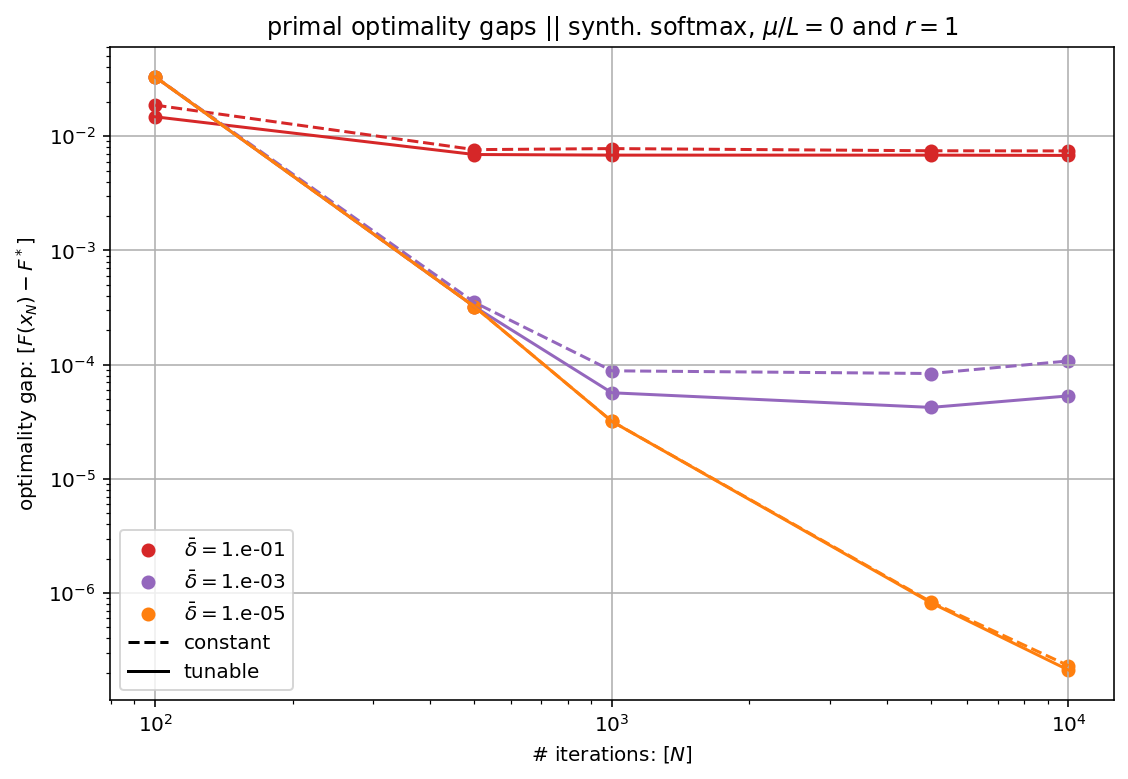

In [244]:
import seaborn as sns
#sns.set_theme(style="darkgrid")

plt.figure(figsize=(9,6))
plt.title('primal optimality gaps || synth. softmax, $\\mu / L = $'+condition_str+' and $r = $'+str(r_wish))

# Plot the responses for different events and regions
selected = df.groupby(['N_ref','bar_delta','r','schedule']).agg('mean')[['GAP']]

for col,delta_tested in zip(colors_delta[:len(balayage_delta)],balayage_delta):
    points_constant = []
    N_constant = []
    points_tunable = []
    N_tunable = []

    for N_tested in balayage_N:
        N_constant.append(N_tested)
        N_tunable.append(N_tested)
        points_tunable.append(selected.loc[(N_tested, delta_tested, r_wish, 'tunable')]['GAP'])
        points_constant.append(selected.loc[(N_tested, delta_tested, r_wish, 'constant')]['GAP'])
    
    plt.scatter(N_constant,points_constant,color=col,label='$\\bar{\\delta} = $'+np.format_float_scientific(delta_tested,3))
    plt.plot(N_constant,points_constant,color=col,linestyle='--')
    plt.scatter(N_tunable,points_tunable,color=col)
    plt.plot(N_tunable,points_tunable,color=col)
    
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# from data
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
line_constant = Line2D([0], [0], label='constant', color='k',linestyle='--')
line_tunable = Line2D([0], [0], label='tunable', color='k',linestyle='-')


# add manual symbols to auto legend
handles.extend([line_constant, line_tunable])

plt.legend(handles=handles)
plt.xlabel('# iterations: [$N$]')
plt.ylabel('optimality gap: [$F(x_N)-F^*$]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.savefig('r_1_paper_synthetic_no_reg.pdf',dpi=600)